##### Copyright 2018 The TensorFlow Authors.

In [36]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Transfer learning with TensorFlow Hub

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

[TensorFlow Hub](https://tfhub.dev/) is a repository of pre-trained TensorFlow models.

This tutorial demonstrates how to:

1. Use models from TensorFlow Hub with `tf.keras`
1. Use an image classification model from TensorFlow Hub
1. Do simple transfer learning to fine-tune a model for your own image classes

## Setup

In [1]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

## An ImageNet classifier

You'll start by using a pretrained classifer model to take an image and predict what it's an image of - no training required!

## Simple transfer learning

But what if you want to train a classifier for a dataset with different classes? You can also use a model from TFHub to train a custom image classier by retraining the top layer of the model to recognize the classes in our dataset.

### Dataset

 For this example you will use the TensorFlow flowers dataset:

In [2]:
#data_root = 'C:/hpcc-data/dropzone/ahs-yes-no'
data_root = 'C:/Work/ML/Carina/open-set/images/faces/students'

Let's load this data into our model using  images off disk using image_dataset_from_directory.

In [3]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_root,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1357 files belonging to 7 classes.
Using 1086 files for training.


The students dataset has number of students classes.

In [4]:
class_names = np.array(train_ds.class_names)
# index 0 is 'no' and index 1 is 'yes'
# These will be used in the final prediction
print(class_names)

['s123450' 's123452' 's123454' 's123455' 's123456' 's123457' 'x4']


TensorFlow Hub's conventions for image models is to expect float inputs in the `[0, 1]` range. Use the `Rescaling` layer to achieve this.

Note: you could also include the `Rescaling` layer inside the model. See this [guide](https://www.tensorflow.org/guide/keras/preprocessing_layers) for a discussion of the tradeoffs.

In [5]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [9]:
# Disable this will allow training without cache
# AUTOTUNE = tf.data.AUTOTUNE
# train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily do transfer learning.

Any [compatible image feature vector model](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) from TensorFlow Hub will work here.

In [7]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" #@param {type:"string"}

Create the feature extractor. Use `trainable=False` to freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.

In [9]:
# Remove the <User>\AppData\Local\Temp\tfhub_modules if this fails
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

It returns a 1280-length vector for each image:

In [10]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


### Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [11]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 7)                 8967      
Total params: 2,266,951
Trainable params: 8,967
Non-trainable params: 2,257,984
_________________________________________________________________


In [12]:
predictions = model(image_batch)

In [13]:
predictions.shape

TensorShape([32, 7])

### Train the model

Use compile to configure the training process:

In [14]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

Now use the `.fit` method to train the model.

To keep this example short train just 2 epochs. To visualize the training progress, use a custom callback to log the loss and accuracy of each batch individually, instead of the epoch average.

In [15]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()

history = model.fit(train_ds, epochs=5,
                    callbacks=[batch_stats_callback])

Epoch 1/5
34/34 [==============================] - 6s 100ms/step - loss: 0.5126 - acc: 0.9000
Epoch 2/5
34/34 [==============================] - 3s 75ms/step - loss: 0.1798 - acc: 1.0000
Epoch 3/5
34/34 [==============================] - 3s 76ms/step - loss: 0.1036 - acc: 1.0000
Epoch 4/5
34/34 [==============================] - 3s 75ms/step - loss: 0.0480 - acc: 1.0000
Epoch 5/5
34/34 [==============================] - 3s 75ms/step - loss: 0.0631 - acc: 1.0000


Now after, even just a few training iterations, we can already see that the model is making progress on the task.

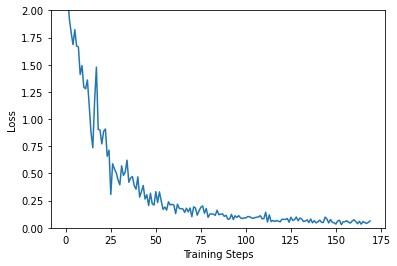

In [16]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

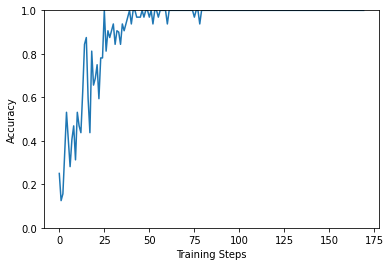

In [17]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

### Check the predictions

To redo the plot from before, first get the ordered list of class names:

In [18]:
predicted_batch = model.predict(image_batch)
print("Prediction Scores")
print("---------------------------")
print(predicted_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

Prediction Scores
---------------------------
[[-3.9731321e+00 -3.8955805e+00 -1.8775160e+00  4.1030121e+00
  -3.1175940e+00 -2.1376390e+00 -1.9041350e+00]
 [-1.6317577e+00 -3.7468371e+00 -7.1628505e-01 -1.2146487e+00
  -3.7465189e+00 -6.6263634e-01  2.6774402e+00]
 [ 3.9859405e+00 -9.7716528e-01 -2.7572997e+00 -1.7443810e+00
  -4.6777275e-01 -5.7095844e-01 -1.9268939e+00]
 [-3.7629955e+00 -2.0024416e+00 -1.7729466e+00  2.7562382e+00
  -5.1106367e+00 -7.9330713e-01 -2.0542979e+00]
 [-2.4529110e-01  3.1892798e+00 -1.6694974e+00 -1.6403352e+00
  -1.5836923e+00 -1.9429283e+00 -1.4020438e+00]
 [-1.8457627e+00 -4.0893974e+00 -1.6142840e+00 -1.5510254e+00
   3.6569800e+00 -3.0509341e+00 -2.2681499e+00]
 [-4.7055473e+00 -4.8669190e+00 -1.1638227e+00  4.2632804e+00
  -2.6954775e+00 -1.8982084e+00 -3.1191745e+00]
 [-3.5310588e+00 -3.5352163e+00 -1.0242506e+00  6.2877733e-01
  -4.7765069e+00  3.2068589e+00 -5.0707513e-01]
 [-3.6204751e+00 -1.2334585e+00 -2.1149616e+00 -1.5692626e-01
  -4.7619734

In [19]:
# convert to probability
predicted_p = tf.nn.softmax(predicted_batch)
predicted_p

<tf.Tensor: shape=(32, 7), dtype=float32, numpy=
array([[3.08303745e-04, 3.33164819e-04, 2.50664796e-03, 9.91753221e-01,
        7.25327816e-04, 1.93251681e-03, 2.44080392e-03],
       [1.21546192e-02, 1.46613538e-03, 3.03617027e-02, 1.84454620e-02,
        1.46660244e-03, 3.20350565e-02, 9.04070377e-01],
       [9.65017736e-01, 6.74661435e-03, 1.13758340e-03, 3.13248020e-03,
        1.12282522e-02, 1.01274289e-02, 2.60990113e-03],
       [1.39381038e-03, 8.10592342e-03, 1.01969661e-02, 9.45085168e-01,
        3.62185150e-04, 2.71595791e-02, 7.69629236e-03],
       [3.00602689e-02, 9.32412326e-01, 7.23549025e-03, 7.44959759e-03,
        7.88374525e-03, 5.50450711e-03, 9.45412647e-03],
       [3.99954570e-03, 4.24240832e-04, 5.04127750e-03, 5.37048420e-03,
        9.81344461e-01, 1.19842612e-03, 2.62162299e-03],
       [1.26267638e-04, 1.07450738e-04, 4.35957080e-03, 9.91755605e-01,
        9.42441693e-04, 2.09172326e-03, 6.16943289e-04],
       [1.06046163e-03, 1.05606241e-03, 1.300732

In [20]:
# Decode prediction
#decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions(predicted_batch, top=2)
#decode_predictions

Plot the result

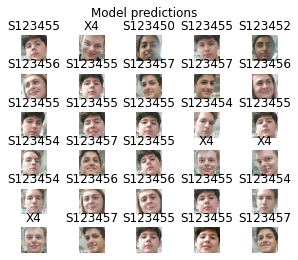

In [21]:

plt.figure(figsize=(5,4
                   ))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n], interpolation="sinc")
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

## Export your model

Now that you've trained the model, export it as a SavedModel for use later on.

In [25]:
t = time.time()

export_path = "C:/tmp/saved_models/ahs-1"
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: C:/tmp/saved_models/ahs-1\assets


INFO:tensorflow:Assets written to: C:/tmp/saved_models/ahs-1\assets


'C:/tmp/saved_models/ahs-1'

Now confirm that we can reload it, and it still gives the same results:

In [27]:
new_model = tf.keras.models.load_model(export_path)
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [41]:

IMAGE_SHAPE = (224, 224)
image_file = 'C:/Work/LexisNexis/HPCC/2021/intern/gnn-cloud/images/test/x100002.bmp'
x100002 = Image.open(image_file).resize(IMAGE_SHAPE)
x100002 = np.array(x100002)/255.0
x100002.shape
result = model.predict(x100002[np.newaxis, ...])
result.shape
predicted_class = np.argmax(result[0], axis=-1)
#index 0 is 'no' and index 1 is 'yes'
class_names[predicted_class]



'no'

In [42]:
image_file = 'C:/Work/LexisNexis/HPCC/2021/intern/gnn-cloud/images/test/s12345600125.bmp'
s123456 = Image.open(image_file).resize(IMAGE_SHAPE)
s123456 = np.array(s123456)/255.0
s123456.shape
result = model.predict(s123456[np.newaxis, ...])
result.shape
predicted_class = np.argmax(result[0], axis=-1)
#index 0 is 'no' and index 1 is 'yes'
class_names[predicted_class]

'yes'

This SavedModel can be loaded for inference later, or converted to [TFLite](https://www.tensorflow.org/lite/convert/) or [TFjs](https://github.com/tensorflow/tfjs-converter).


## Learn more

Check out more [tutorials](https://www.tensorflow.org/hub/tutorials) for using image models from TensorFlow Hub.